# K-Means w/ PCA on Pneumonia X-Rays

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
import os
import time

In [7]:
from sklearn.preprocessing import normalize

In [8]:
#Helper function to get cluster_plot
def get_cluster_plot(rows, Kmus): 
    '''
    : get a plot of what different clusters represent
    : takes as input the cluster location matrix
    '''
    fig,axs = plt.subplots(rows,5, figsize = (15,9))
    for i in range(len(Kmus)):
        cluster = Kmus[i].reshape(256,-1) * 255
        axs[i//5][i%5].imshow(cluster, cmap = plt.cm.binary)
        axs[i//5][i%5].set_title(f'Image {i + 1}')

## Setup: Reading and formatting images

The data used in this notebook consist of lung x-rays from healthy individuals and individuals infected with pneumonia. Although the data comes with the identifying labels, we will remove them in order to create an unlabeled dataset. 

In [9]:
#Function to process .jpeg images into array for KMeans
def process_imgKMeans():
    print("Reading images for KMeans")
    array = []
    dim = (256, 256)
    images = glob.glob("./chest_xray/train/NORMAL/*.jpeg")
    for image_file in images:
        # Resize images and remove RGB
        image = cv2.resize(cv2.imread(image_file), dim, interpolation = cv2.INTER_AREA)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        array.append(image)

    images = glob.glob("./chest_xray/train/PNEUMONIA/*.jpeg")
    for image_file in images:
        # Resize images and remove RGB
        image = cv2.resize(cv2.imread(image_file), dim, interpolation = cv2.INTER_AREA)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        array.append(image)

    return array

In [10]:
#Function to process .jpeg images into array for PCA
def process_imgPCA():
    print("Reading images for PCA")
    array = []
    dim = (256, 256)
    images = glob.glob("./chest_xray/train/NORMAL/*.jpeg")
    for image_file in images:
        image = cv2.resize(cv2.imread(image_file), dim, interpolation = cv2.INTER_AREA)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).T
        array.append(image)

    images = glob.glob("./chest_xray/train/PNEUMONIA/*.jpeg")
    for image_file in images:
        image = cv2.resize(cv2.imread(image_file), dim, interpolation = cv2.INTER_AREA)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).T
        array.append(image)
    
    return array

In [11]:
#processing images
x_raysKMeans = process_imgKMeans()
x_raysPCA = process_imgPCA()

Reading images for KMeans
Reading images for PCA


In [12]:
#convert to arrays
x_raysKMeans, x_raysPCA = np.array(x_raysKMeans), np.array(x_raysPCA)

## Visualizing the data:

We can plot images of healthy lungs and infected lungs to visualize the difference between both.

<ipython-input-13-fcb80072e64d>:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


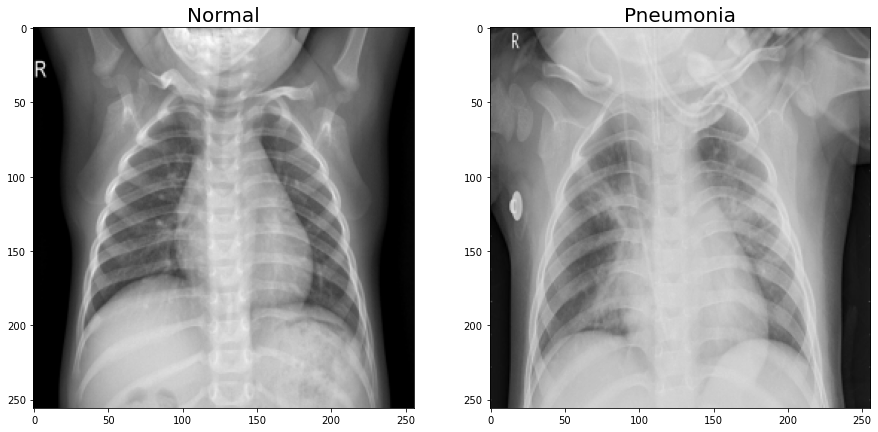

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(15,9))
axs[0].set_title("Normal", fontsize="20")
axs[0].imshow(x_raysKMeans[2].reshape(256,256), cmap=plt.get_cmap('gray'))
axs[1].set_title("Pneumonia", fontsize="20")
axs[1].imshow(x_raysKMeans[-2].reshape(256,256), cmap=plt.get_cmap('gray'))

fig.show()

From the images above, we can clearly see that lungs with pneumonia look more cloudy than healthy lungs. When observing the images, the cloudiness of the lungs are a common difference between normal and infected lungs.

In [14]:
#shuffle
np.random.shuffle(x_raysKMeans)
np.random.shuffle(x_raysPCA)

In [15]:
#Reshape array to 1D nparray
x_raysKMeans = x_raysKMeans.reshape(5216, -1)/255

In [16]:
#Reshape array to 1D nparray and take transpose to create column vectors
x_raysPCA = x_raysPCA.reshape(5216, -1)/255
x_raysPCA = x_raysPCA.T

## K-means:

Using K-means, we can attempt to find some underlying patterns for our images by assigning our images to certain clusters. We know that the dataset contains x-rays of both healthy and infected lungs and from the visualization, we can clearly see a difference in cloudiness. So we can train our model to try and identify this difference.

In [17]:
#Helper functions for KMeans
def calcSqDistances(X, Kmus):
    res = np.zeros((X.shape[0], Kmus.shape[0]))
    for i in range(X.shape[0]):
        for j in range(Kmus.shape[0]):
            res[i, j] = np.linalg.norm(X[i] - Kmus[j])
    return res

def determineRnk(sqDmat):
    Rnk = np.tile(0, (sqDmat.shape[0], sqDmat.shape[1]))
    for i in range(sqDmat.shape[0]):
        index = np.argmin(sqDmat[i])
        Rnk[i][index] = 1
    
    return Rnk

def recalcMus(X, Rnk):
    recalc = np.zeros((Rnk.shape[1], X.shape[1]))
    
    for i in range(Rnk.shape[1]):
        recalc[i,:] = np.sum((np.array([Rnk[:,i]]).T) * X, axis = 0)/(np.sum(Rnk[:,i], axis = 0))
    return recalc

In [18]:
def runKMeans(matrix, K):
    #load data file specified by fileString from Bishop book
    start = time.time()
    X = matrix

    #determine and store data set information
    N, D = X.shape

    #allocate space for the K mu vectors
    Kmus = np.zeros((K, D))

    #initialize cluster centers by randomly picking points from the data
    rand_inds = np.random.permutation(N)
    Kmus = X[rand_inds[0:K],:]

    #specify the maximum number of iterations to allow
    maxiters = 1000

    for iter in range(maxiters):
        #assign each data vector to closest mu vector as per Bishop (9.2)
        #do this by first calculating a squared distance matrix where the n,k entry
        #contains the squared distance from the nth data vector to the kth mu vector

        #sqDmat will be an N-by-K matrix with the n,k entry as specfied above
        sqDmat = calcSqDistances(X, Kmus)

        #given the matrix of squared distances, determine the closest cluster
        #center for each data vector

        #R is the "responsibility" matrix
        #R will be an N-by-K matrix of binary values whose n,k entry is set as
        #per Bishop (9.2)
        #Specifically, the n,k entry is 1 if point n is closest to cluster k,
        #and is 0 otherwise
        Rnk = determineRnk(sqDmat)

        KmusOld = Kmus
#         plotCurrent(X, Rnk, Kmus)
#         time.sleep(1)

        #recalculate mu values based on cluster assignments as per Bishop (9.4)
        Kmus = recalcMus(X, Rnk)





        #check to see if the cluster centers have converged.  If so, break.
        diff = np.sum(np.abs(KmusOld.reshape((-1, 1)) - Kmus.reshape((-1, 1))))
        print(diff)
        if diff < 1e-6:
            print(iter)
            break

    # plotCurrent(X, Rnk, Kmus)
    end = time.time()
    print("Total time: {}".format(end - start))
    return Kmus

In [19]:
xray_kmeans = runKMeans(x_raysKMeans, 2)

17559.52060051749
4290.390130824234
2532.002898858097
585.1421631504778
305.7001497280941
195.9682482652488
132.9358858010785
90.68664831559032
46.70878889079612
42.24729973951303
44.60655888033186
48.43038381351808
54.20731750375575
34.84137871504584
16.263474389238514
27.419384661673266
20.772565726567443
11.325282741050376
3.967461512583386
6.677922877439544
5.524157894330022
0.0
21
Total time: 76.54443740844727


## Results from K-Means:

We can try to cluster K-means with 2 clusters (normal and pneumonia) to determine if K-means with 2 clusters is enough.

Not all clusters have enough images
No pictures in cluster 2
No pictures in cluster 2
No pictures in cluster 2
No pictures in cluster 2
No pictures in cluster 2


<ipython-input-20-3d32466373d7>:34: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


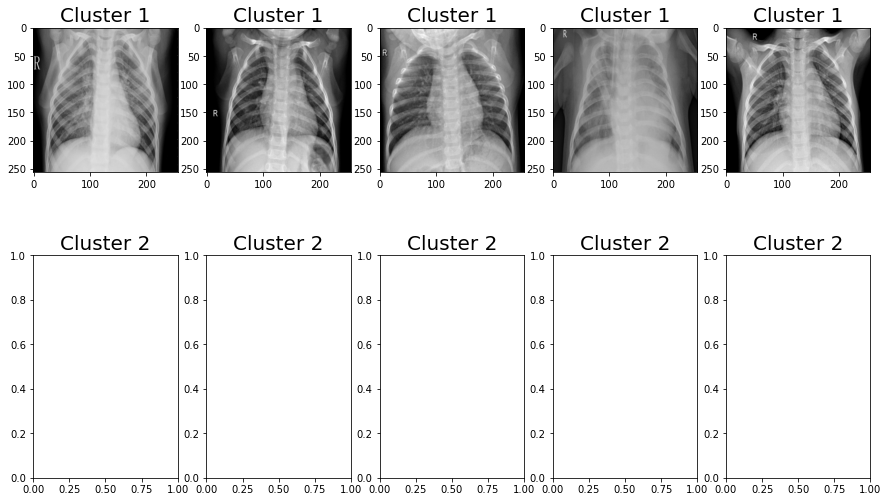

In [20]:
indices = []

for i in range(2):
  indices.append([])

i = 0
j = 0
while i < 5*2:
    if (j == xray_kmeans.shape[1]):
        print("Not all clusters have enough images")
        break
    val = max(xray_kmeans[:,j])
    pos = np.where(xray_kmeans[:,j] == val)[0][0]
    if (len(indices[pos]) != 5):
        indices[pos].append(j)
        i += 1
        
    j += 1

fig, axs = plt.subplots(2, 5, figsize=(15,9))
for col in range(5):
      try:
        axs[0][col].set_title("Cluster 1", fontsize="20")
        axs[0][col].imshow(x_raysKMeans[indices[0][col]].reshape(256,256), cmap=plt.get_cmap('gray'))
      except:
        print("No more pictures in cluster 1")

      try:
        axs[1][col].set_title("Cluster 2", fontsize="20")
        axs[1][col].imshow(x_raysKMeans[indices[1][col]].reshape(256,256), cmap=plt.get_cmap('gray'))
      except:
        print("No pictures in cluster 2")

fig.show()

In [21]:
print(xray_kmeans)

[[0.21668904 0.22654227 0.24546137 ... 0.07835704 0.0792794  0.08656882]
 [0.16427214 0.16929521 0.18952311 ... 0.06154821 0.06332491 0.07058376]]


From the results above, it doesn't seem like K-means with 2 clusters isn't enough to find any underlying patterns. Lets try 4.

In [22]:
# four_clusters = runKMeans(x_raysKMeans, 4)

In [23]:
# indices = []

# for i in range(4):
#   indices.append([])

# i = 0
# j = 0
# while i < 5*4:
#     if (j == xray_kmeans.shape[1]):
#         print("Not all clusters have enough images")
#         break
#     val = max(four_clusters[:,j])
#     pos = np.where(four_clusters[:,j] == val)[0][0]
#     if (len(indices[pos]) != 5):
#         indices[pos].append(j)
#         i += 1
        
#     j += 1

# print(indices)

## PCA:


In [24]:
def eigsort(V, eigvals):
    
    # Sort the eigenvalues from largest to smallest. Store the sorted
    # eigenvalues in the column vector lambd.
    lohival = np.sort(eigvals)
    lohiindex = np.argsort(eigvals)
    lambd = np.flip(lohival)
    index = np.flip(lohiindex)
    Dsort = np.diag(lambd)
    
    # Sort eigenvectors to correspond to the ordered eigenvalues. Store sorted
    # eigenvectors as columns of the matrix vsort.
    M = np.size(lambd)
    Vsort = np.zeros((M, M))
    for i in range(M):
        Vsort[:,i] = V[:,index[i]]
    return Vsort, Dsort, lambd

#Helper function to normalize matrix

def normc(Mat):
    return normalize(Mat, norm='l2', axis=0)

#Helper function to plot skree plot of lambdas

def skree(lambd):
    plt.plot(np.arange(len(lambd)) + 1, lambd, 'ro-', linewidth = 2)
    plt.title("Scree Plot")
    plt.xlabel("Principal Component")
    plt.ylabel("Eigenvalue")
    return

#Helper function to return variance explained and cumulataive sum of variance

def explained_variance(eigen_values):

  #explains how much of the data each component describes 
    var_exp = [(i/sum(eigen_values))*100 for i in eigen_values]
  
  #cumsum of var_exp for easier visualization
    cumsum_var = np.cumsum(var_exp)

    return var_exp, cumsum_var

#Helper function to viewcolumn vectors

def viewcolumn(columnvector):
    plt.imshow(columnvector.reshape(
        [256, 256], order='F'), cmap=plt.get_cmap('gray'))
    plt.show()

#Helper function to retrive indice where threshold variance is explained
#e.g. returns i = 4 if first 5 components explain threshold variance

def indexfinder(cumsum, threshold):
    for i in range(len(cumsum)):
        if cumsum[i] >= threshold:
            return i

In [25]:
x_raysPCA.shape

(65536, 5216)

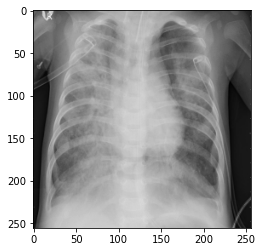

In [26]:
viewcolumn(x_raysPCA[:,0])

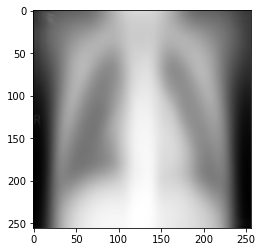

In [27]:
mean_xrays = np.mean(x_raysPCA, axis = 1)[:,None]
viewcolumn(mean_xrays)

In [28]:
A = (x_raysPCA - mean_xrays).real.astype(np.float32)
cov = np.divide(A.T@A, 5216)

In [29]:
eigvals, V = np.linalg.eig(cov)
Vsort, Dsort, lambd = eigsort(V, eigvals)

<ipython-input-24-b1edd943f5b5>:16: ComplexWarning: Casting complex values to real discards the imaginary part
  Vsort[:,i] = V[:,index[i]]


In [30]:
U = A @ Vsort
U = normc(U)

C:\Users\wilso\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


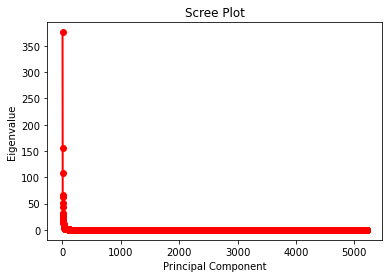

In [31]:
#Skree plot
#Elbow at near right angle, extreme drop off of variance explained by components 
#following elbow
skree(lambd)

In [32]:
exp, cumsum = explained_variance(eigvals)
cumsum

array([ 25.24716783+0.j,  35.67791558+0.j,  42.91349136+0.j, ...,
        99.99959849+0.j,  99.9997993 +0.j, 100.        +0.j])

In [33]:
indexfinder(cumsum, 96)

647

In [34]:
reduced_U = U[:625]
x_rays_temp = x_raysPCA[:,:625] - mean_xrays

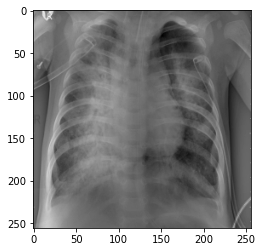

(65536, 625)

In [35]:
viewcolumn(x_rays_temp[:,0])
reduced_U.shape
x_rays_temp.shape

In [36]:
reduced_xrays = reduced_U.T @ x_rays_temp[:625]

In [37]:
zhat = U[:,:625] @ reduced_xrays[:625] + mean_xrays

In [38]:
#shape comparisons
reduced_xrays.shape, x_raysPCA.shape, zhat.shape

((5216, 625), (65536, 5216), (65536, 625))

## KMeans with PCA:

Before we saw that 2 clusters wasn't enough for K-Means. We can try again this time using PCA.

In [39]:
#KMeans on PCA reduced xrays, significantly faster
reduced_test = runKMeans(reduced_xrays, 2)

16.474816564248467
3.1383746865033757
1.350293656500237
1.4793971819563088
2.1221248956733305
2.881124687439258
5.193476755076619
8.75851806825662
16.363916456980647
27.243096985980472
30.34051340791228
21.0582744635847
11.898701211392998
3.6544349980901334
0.0
14
Total time: 2.1492600440979004


In [40]:
print(reduced_test.shape)

(2, 625)


In [41]:
#Initialize cluster arrays for visualization
cluster1, cluster2 = [], []

In [42]:
#Retrieving image indices that are in cluster 1 and 2

i = 0
j = 0
while i < 20:
    if (reduced_test[:,j][0] < reduced_test[:,j][1]):
            cluster2.append(j)
            i += 1
    j += 1
j = 0
i = 0
while i < 20:
    if (reduced_test[:,j][0] > reduced_test[:,j][1]):
            cluster1.append(j)
            i += 1
    j += 1

In [43]:
#cluster1, cluster2

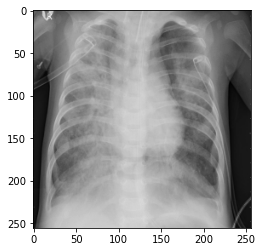

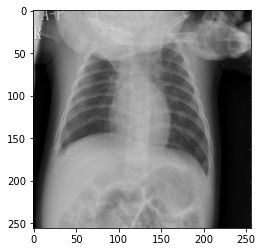

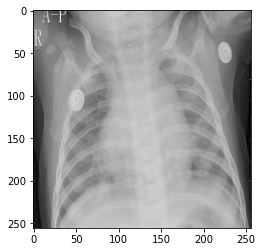

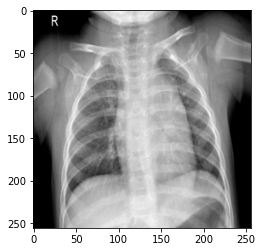

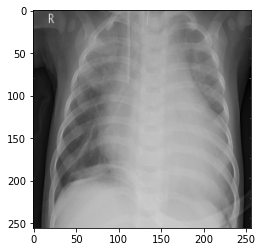

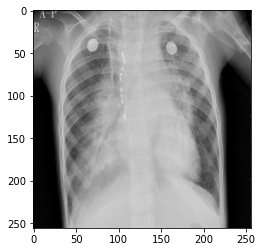

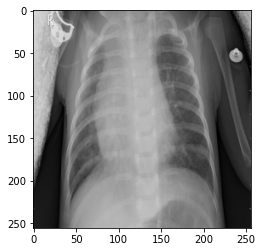

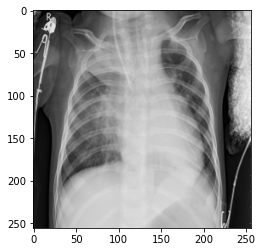

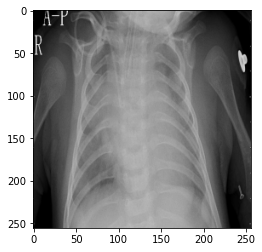

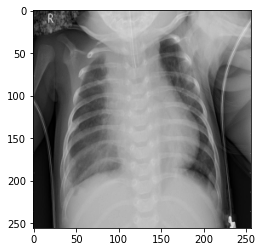

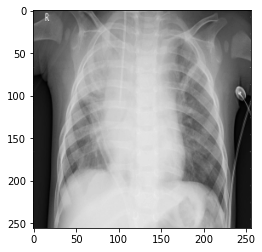

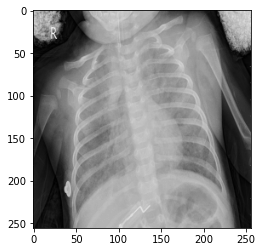

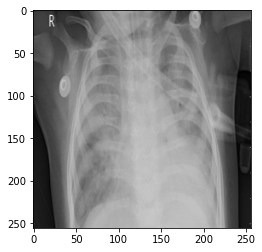

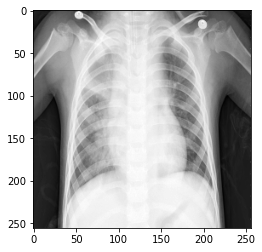

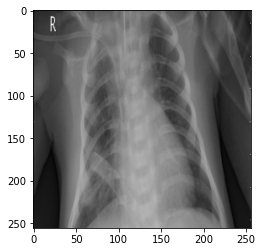

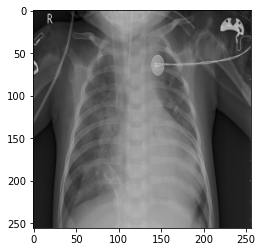

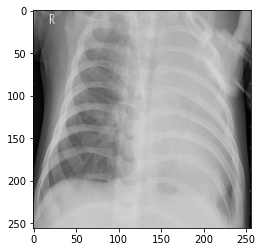

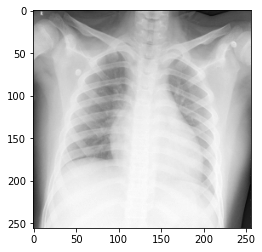

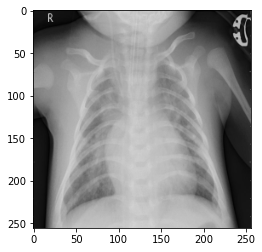

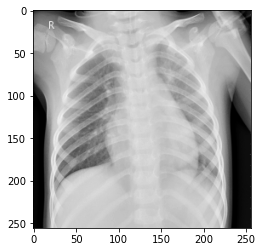

In [44]:
#visualizing cluster 1
for i in cluster1:
    viewcolumn(x_raysPCA[:,i])

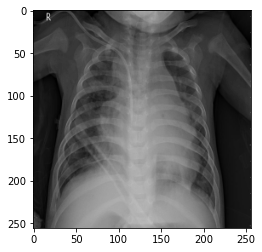

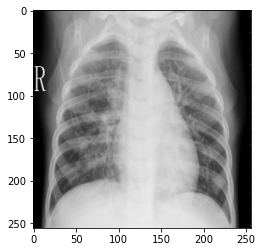

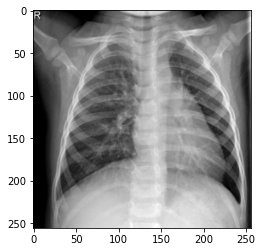

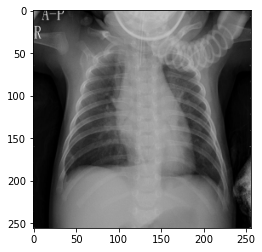

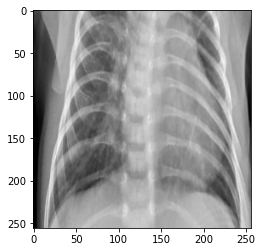

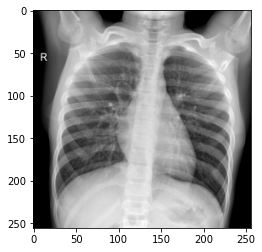

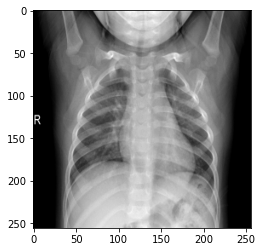

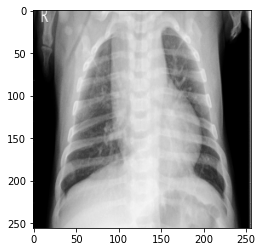

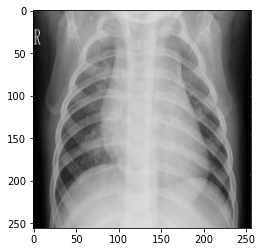

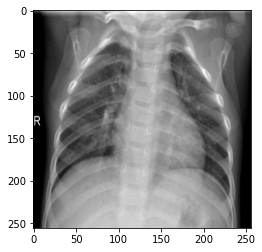

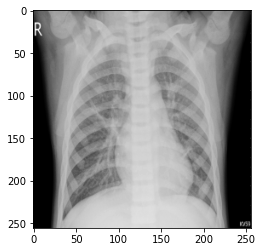

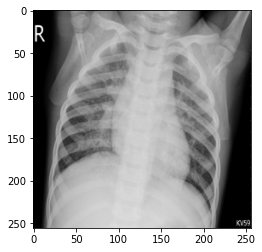

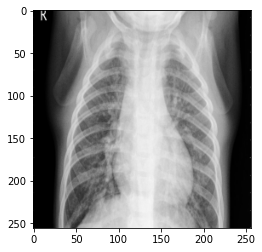

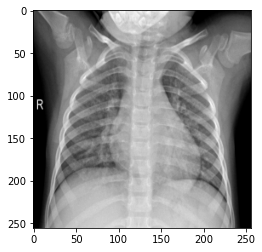

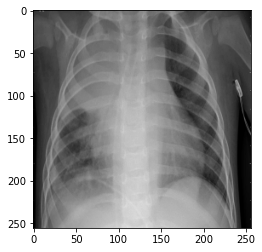

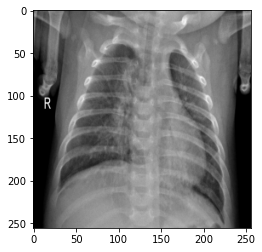

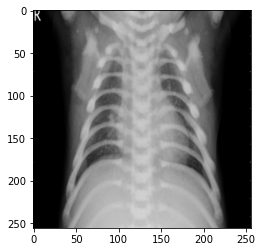

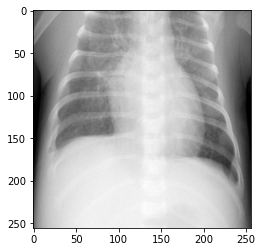

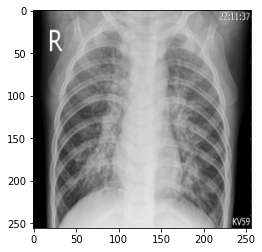

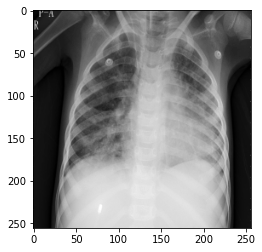

In [46]:
#Visualizing cluster 2
for i in cluster2:
    viewcolumn(x_raysPCA[:,i])

## Comparing Runtime for K-means w/ and w/o PCA

In [47]:
#Time test
runKMeans(x_raysKMeans[:625], 10)

50863.226748434565
10314.400893824662
5510.101126356574
4402.927968341025
3693.416583238337
2995.746212946449
3452.540428108843
3162.403962869647
2222.889539525373
1562.5784477372063
880.1448755767891
1618.7938157663084
1705.6502149963715
1319.9675485301157
870.0599224531816
395.11323644359277
793.6592065736816
662.6312972699457
772.5683055765893
355.09593506145075
0.0
20
Total time: 37.82685136795044


array([[0.14354765, 0.14163247, 0.15978112, ..., 0.06511628, 0.0745098 ,
        0.08344733],
       [0.32601307, 0.32941176, 0.3253159 , ..., 0.19433551, 0.18309368,
        0.1827451 ],
       [0.21183117, 0.22871386, 0.2331007 , ..., 0.02419408, 0.02472582,
        0.02512463],
       ...,
       [0.22431373, 0.22346405, 0.23052288, ..., 0.10183007, 0.10823529,
        0.1154902 ],
       [0.10903247, 0.13198329, 0.18887817, ..., 0.00630023, 0.00739312,
        0.01131469],
       [0.19302832, 0.21210361, 0.25044783, ..., 0.01045752, 0.01249092,
        0.02706366]])

In [48]:
runKMeans(reduced_xrays, 10)

118.98791375162315
123.15729883961664
120.78732217073942
99.44271545241
88.53060560827295
80.36886206097044
57.13916405539828
64.11700685946498
69.9903858299599
66.78643348934796
78.7286469795468
32.92954542078869
34.309147925398214
42.40435791786746
56.450791545007306
68.34494746614747
88.26035508812136
62.139107905397296
41.65524324499921
38.797526167904806
66.3381426744079
152.48201784804715
112.29619996505382
5.111007781001258
5.801555264424389
6.418150051811962
4.264937623896713
7.178629384926902
2.570244969796969
0.7628493788838041
0.08090882609005512
0.05577112992733106
0.11075296070094573
0.11859584460520405
0.0750093561547244
0.6404019112265087
0.060357203033797685
0.04546800534854695
0.020984973362845258
0.009898753922975475
0.0
40
Total time: 17.698585748672485


array([[-0.64301074,  0.10449936,  1.13167645, ..., -0.70654561,
         1.14217315, -1.41207603],
       [ 0.54405234, -0.09987329, -0.94954429, ...,  0.61504381,
        -0.96054411,  1.22480692],
       [-0.0031889 ,  0.00164879,  0.01618949, ..., -0.0082444 ,
         0.01537749, -0.01807843],
       ...,
       [-0.14102591,  0.01568582,  0.28255376, ..., -0.19576382,
         0.28763484, -0.33339475],
       [ 0.28228027, -0.09243173, -0.42821779, ...,  0.33546946,
        -0.44519581,  0.69387004],
       [-0.09441957,  0.02629437,  0.13991936, ..., -0.11577762,
         0.14479959, -0.23757453]])